<h1 align="center"><font size="5">Predicting Loan defaulters using Classification with Python</font></h1>


In [340]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's import the dataset


### Load Data From CSV File


In [342]:
df = pd.read_csv(loan_train_csv)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [343]:
df.shape

(346, 10)

### Convert to date time object


In [344]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [345]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [346]:
#% of Loans paid off and in collection
(df['loan_status'].value_counts()/df['loan_status'].count()) * 100

PAIDOFF       75.144509
COLLECTION    24.855491
Name: loan_status, dtype: float64

In [347]:
#!pip install matplotlib==3.1.3

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [348]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

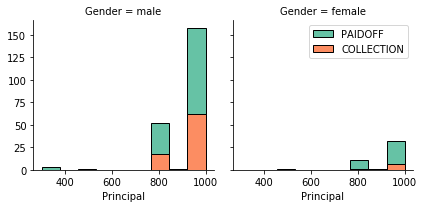

In [349]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

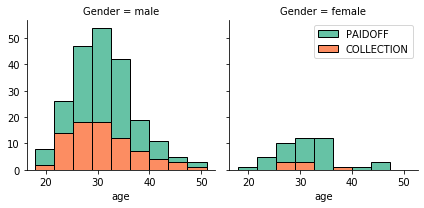

In [350]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


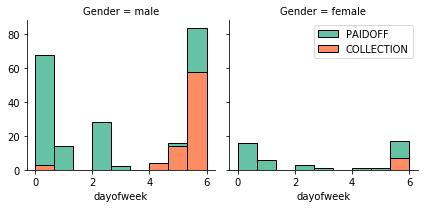

In [351]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [352]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [353]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [354]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding


In [355]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [356]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [357]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [358]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [359]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance 


In [360]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [361]:
X.shape

(346, 8)

In [362]:
#pip install -U sklearn

In [363]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=14)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification


Building our models using the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression


# K Nearest Neighbor(KNN)


In [364]:
from sklearn.neighbors import KNeighborsClassifier

In [365]:
#Training our Model
k1 = 3  
KNN = KNeighborsClassifier(n_neighbors = k1).fit(X_train,y_train)
KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [366]:
yhat_knn = KNN.predict(X_test)
yhat_knn[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [367]:
yhat_knn_df = pd.DataFrame(yhat_knn, columns = ['Loan_Status'])
yhat_knn_df.head()

,Loan_Status
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [368]:
#% of Loans paid off and in collection loans in our predicted set
(yhat_knn_df['Loan_Status'].value_counts()/yhat_knn_df['Loan_Status'].count()) * 100

PAIDOFF       84.285714
COLLECTION    15.714286
Name: Loan_Status, dtype: float64

In [369]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, KNN.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_knn))

Train set Accuracy:  0.8297101449275363
Test set Accuracy:  0.7571428571428571


In [370]:
#f1Score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_knn, average='weighted') 

0.7354901699729286

In [371]:
#Jaccard Index
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_knn,pos_label='PAIDOFF')

0.734375

In [372]:
#Iterating over different KNN models with different K values

In [373]:
Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=KNN.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)

    
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])

mean_acc

array([0.64, 0.67, 0.76, 0.7 , 0.73, 0.74, 0.77, 0.76, 0.74, 0.74, 0.8 ])

In [374]:
std_acc

array([0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [375]:
#Plotting mean_acc to visualize the optimal K value

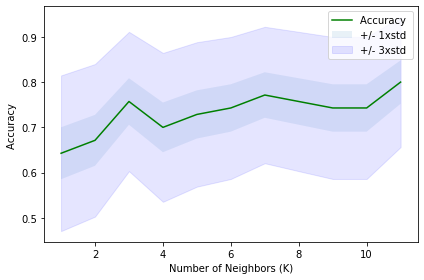

In [376]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="blue")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [377]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8 with k= 11


In [378]:
#Retraining our Model with the optimal value of K
k = 11  
optimal_knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
optimal_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [379]:
yhat_knn_opt = optimal_knn.predict(X_test)
yhat_knn_opt[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [380]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, optimal_knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_knn_opt))

Train set Accuracy:  0.7789855072463768
Test set Accuracy:  0.8


In [381]:
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat_knn_opt))

              precision    recall  f1-score   support

  COLLECTION       0.75      0.33      0.46        18
     PAIDOFF       0.81      0.96      0.88        52

    accuracy                           0.80        70
   macro avg       0.78      0.65      0.67        70
weighted avg       0.79      0.80      0.77        70



In [382]:
#f1Score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_knn_opt, average='weighted') 

0.7703103913630228

In [383]:
#Our Optimal K- nearest neigbour Model has a 96% acurracy on predicting Loans that were paid off on the test set

In [384]:
#Jaccard Index
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_knn_opt,pos_label='PAIDOFF')

0.78125

In [385]:
yhat_knn_opt

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

# Decision Tree


In [386]:
from sklearn.tree import DecisionTreeClassifier

In [387]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [388]:
#Training our model
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [389]:
#Prediction
pred_tree = loanTree.predict(X_test)

In [390]:
pred_tree

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [391]:
#Checking our Training and Test set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanTree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, pred_tree))

Train set Accuracy:  0.7644927536231884
Test set Accuracy:  0.7


In [392]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [393]:
#Visualizing our Decision Tree
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [394]:
Feature.shape

(346, 8)

In [395]:
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [396]:
y.shape

(346,)

In [397]:
df_tree = Feature.copy()
df_tree.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [398]:
df_tree['loan_status']=y
df_tree.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college,loan_status
0,1000,30,45,0,0,0,1,0,PAIDOFF
1,1000,30,33,1,0,1,0,0,PAIDOFF
2,1000,15,27,0,0,0,0,1,PAIDOFF
3,1000,30,28,1,1,0,0,1,PAIDOFF
4,1000,30,29,0,1,0,0,1,PAIDOFF


In [399]:
df_tree.shape

(346, 9)

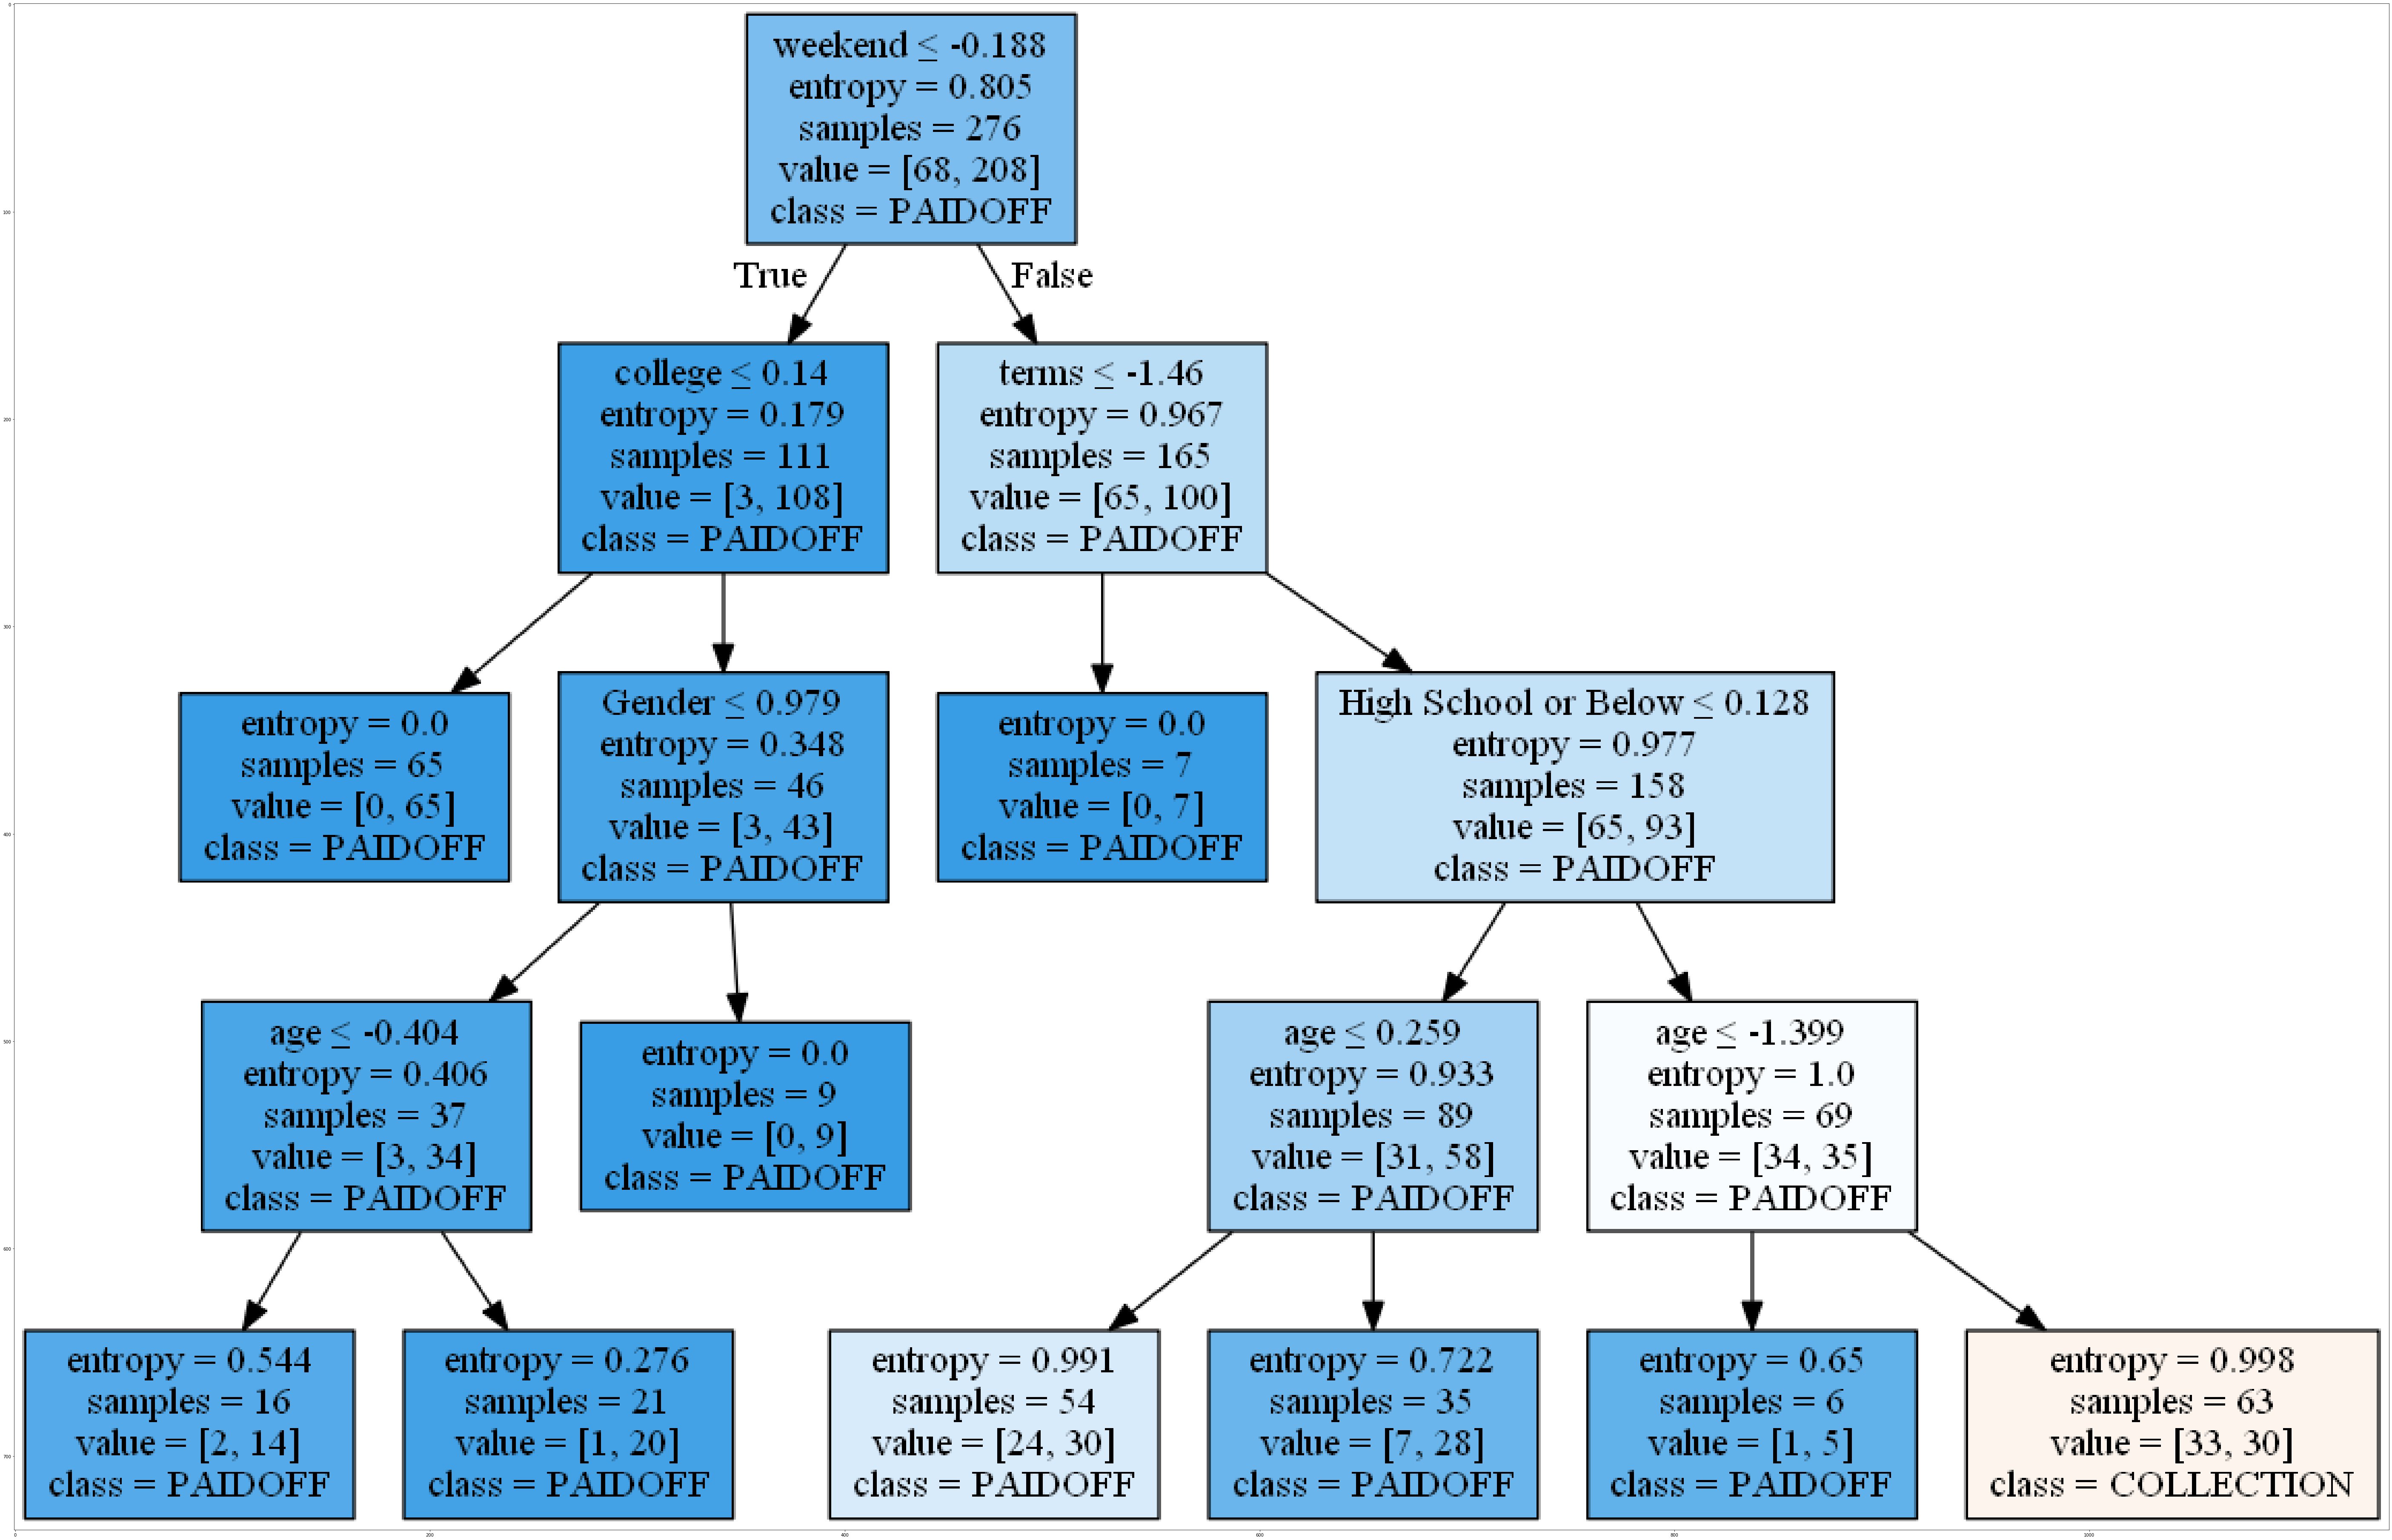

In [400]:
dot_data = StringIO()
filename = "LoanTree.png"
featureNames = df_tree.columns[0:8]
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [401]:
#Classification Report
print (classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

  COLLECTION       0.38      0.28      0.32        18
     PAIDOFF       0.77      0.85      0.81        52

    accuracy                           0.70        70
   macro avg       0.58      0.56      0.56        70
weighted avg       0.67      0.70      0.68        70



In [402]:
#f1Score
f1_score(y_test, pred_tree, average='weighted') 

0.6826871855578573

In [403]:
#Jaccard Index
jaccard_score(y_test, pred_tree,pos_label='PAIDOFF')

0.676923076923077

# Support Vector Machine


In [404]:
#Initializing our SVM
from sklearn import svm
svm_rbf = svm.SVC(kernel='rbf')

In [405]:
#Fitting the model with the training Data
svm_rbf.fit(X_train, y_train) 

C:\Users\seyi.aideyan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [406]:
#Making Predictions
yhat_svm_rbf = svm_rbf.predict(X_test)
yhat_svm_rbf [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [407]:
#Evaluating the model

In [408]:
#Checking our Training and Test set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_rbf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_svm_rbf))

Train set Accuracy:  0.7789855072463768
Test set Accuracy:  0.7428571428571429


In [409]:
from sklearn.metrics import confusion_matrix
import itertools

In [410]:
#Plotting Confusuion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50  2]
 [16  2]]


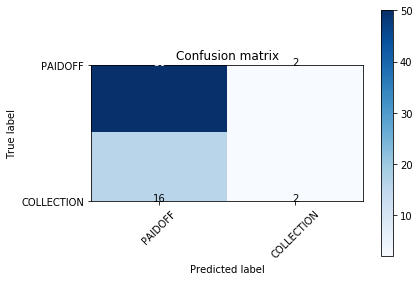

In [411]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_svm_rbf, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [412]:
#Classification Report
print (classification_report(y_test, yhat_svm_rbf))

              precision    recall  f1-score   support

  COLLECTION       0.50      0.11      0.18        18
     PAIDOFF       0.76      0.96      0.85        52

    accuracy                           0.74        70
   macro avg       0.63      0.54      0.51        70
weighted avg       0.69      0.74      0.68        70



In [413]:
#f1 Score
f1_score(y_test, yhat_svm_rbf, average='weighted') 

0.6762931983270967

In [414]:
#Jaccard Score
jaccard_score(y_test, yhat_svm_rbf,pos_label='PAIDOFF')

0.7352941176470589

In [415]:
#Using different Kernel functons to see if the model improves

In [416]:
#Using Linear Kernel Function
svm_lin = svm.SVC(kernel='linear')

In [417]:
#Fitting the model with the training Data
svm_lin.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [418]:
#Making Predictions
yhat_svm_lin = svm_lin.predict(X_test)
yhat_svm_lin [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [419]:
#Checking our Training and Test set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_lin.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_svm_lin))

Train set Accuracy:  0.7536231884057971
Test set Accuracy:  0.7428571428571429


In [420]:
#Classification Report
print (classification_report(y_test, yhat_svm_lin))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        18
     PAIDOFF       0.74      1.00      0.85        52

    accuracy                           0.74        70
   macro avg       0.37      0.50      0.43        70
weighted avg       0.55      0.74      0.63        70



C:\Users\seyi.aideyan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [421]:
#f1 Score
f1_score(y_test, yhat_svm_lin, average='weighted') 

C:\Users\seyi.aideyan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6332552693208431

In [422]:
#Jaccard Score
jaccard_score(y_test, yhat_svm_lin,pos_label='PAIDOFF')

0.7428571428571429

In [423]:
#Using Polynomial Kernel function

In [424]:
svm_poly = svm.SVC(kernel='poly')

In [425]:
#Fitting the model with the training Data
svm_poly.fit(X_train, y_train) 

C:\Users\seyi.aideyan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [426]:
#Making Predictions
yhat_svm_poly = svm_poly.predict(X_test)
yhat_svm_poly [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [427]:
#Checking our Training and Test set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_poly.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_svm_poly))

Train set Accuracy:  0.782608695652174
Test set Accuracy:  0.7285714285714285


In [428]:
#Classification Report
print (classification_report(y_test, yhat_svm_poly))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        18
     PAIDOFF       0.74      0.98      0.84        52

    accuracy                           0.73        70
   macro avg       0.37      0.49      0.42        70
weighted avg       0.55      0.73      0.63        70



In [429]:
#f1 Score
f1_score(y_test, yhat_svm_poly, average='weighted') 

0.6262101534828807

In [430]:
#Jaccard Score
jaccard_score(y_test, yhat_svm_poly,pos_label='PAIDOFF')

0.7285714285714285

In [431]:
#Training with Sigmoid function

In [432]:
svm_sig = svm.SVC(kernel='sigmoid')

In [433]:
#Fitting the model with the training Data
svm_sig.fit(X_train, y_train) 

C:\Users\seyi.aideyan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [434]:
#Making Predictions
yhat_svm_sig = svm_sig.predict(X_test)
yhat_svm_sig [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [435]:
#Checking our Training and Test set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, svm_sig.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_svm_sig))

Train set Accuracy:  0.7101449275362319
Test set Accuracy:  0.6857142857142857


In [436]:
#Classification Report
print (classification_report(y_test, yhat_svm_sig))

              precision    recall  f1-score   support

  COLLECTION       0.25      0.11      0.15        18
     PAIDOFF       0.74      0.88      0.81        52

    accuracy                           0.69        70
   macro avg       0.50      0.50      0.48        70
weighted avg       0.62      0.69      0.64        70



In [437]:
#f1 Score
f1_score(y_test, yhat_svm_sig, average='weighted') 

0.6390591864276075

In [438]:
#Jaccard Score
jaccard_score(y_test, yhat_svm_sig,pos_label='PAIDOFF')

0.6764705882352942

# Logistic Regression


In [439]:
from sklearn.linear_model import LogisticRegression

In [440]:
log_reg = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
log_reg

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [441]:
yhat_lr = log_reg.predict(X_test)
yhat_lr

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [442]:
#Evaluation Score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat_lr, labels=['PAIDOFF','COLLECTION']))

[[52  0]
 [18  0]]


Confusion matrix, without normalization
[[52  0]
 [18  0]]


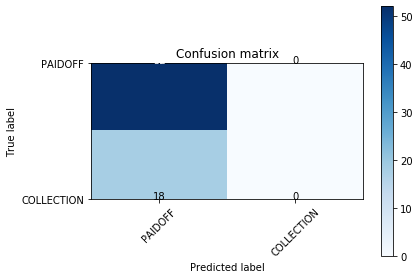

In [443]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_lr, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [444]:
#Checking our Training and Test set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, log_reg.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_lr))

Train set Accuracy:  0.7463768115942029
Test set Accuracy:  0.7428571428571429


In [445]:
print (classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        18
     PAIDOFF       0.74      1.00      0.85        52

    accuracy                           0.74        70
   macro avg       0.37      0.50      0.43        70
weighted avg       0.55      0.74      0.63        70



C:\Users\seyi.aideyan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [446]:
#f1 Score
f1_score(y_test, yhat_lr, average='weighted') 

C:\Users\seyi.aideyan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6332552693208431

In [447]:
#Jaccard Score
jaccard_score(y_test, yhat_lr,pos_label='PAIDOFF')

0.7428571428571429

In [448]:
#Probability
lr_prob = log_reg.predict_proba(X_test)
lr_prob

array([[0.33, 0.67],
       [0.33, 0.67],
       [0.34, 0.66],
       [0.44, 0.56],
       [0.35, 0.65],
       [0.46, 0.54],
       [0.33, 0.67],
       [0.5 , 0.5 ],
       [0.42, 0.58],
       [0.48, 0.52],
       [0.37, 0.63],
       [0.4 , 0.6 ],
       [0.46, 0.54],
       [0.47, 0.53],
       [0.5 , 0.5 ],
       [0.28, 0.72],
       [0.33, 0.67],
       [0.48, 0.52],
       [0.42, 0.58],
       [0.4 , 0.6 ],
       [0.33, 0.67],
       [0.27, 0.73],
       [0.48, 0.52],
       [0.45, 0.55],
       [0.4 , 0.6 ],
       [0.46, 0.54],
       [0.32, 0.68],
       [0.4 , 0.6 ],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.3 , 0.7 ],
       [0.47, 0.53],
       [0.33, 0.67],
       [0.33, 0.67],
       [0.48, 0.52],
       [0.31, 0.69],
       [0.31, 0.69],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.46, 0.54],
       [0.44, 0.56],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.36, 0.64],
       [0.3 , 0.7 ],
       [0.42, 0.58],
       [0.48, 0.52],
       [0.5 ,

In [449]:
#Log Loss
from sklearn.metrics import log_loss
log_loss(y_test, lr_prob)

0.5554957307929707

In [450]:
#Changing complexity parameter
log_reg1 = LogisticRegression(C=3, solver='lbfgs')
log_reg1.fit(X_train,y_train)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [451]:
yhat_lr1 = log_reg1.predict(X_test)
yhat_lr1

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

Confusion matrix, without normalization
[[51  1]
 [16  2]]


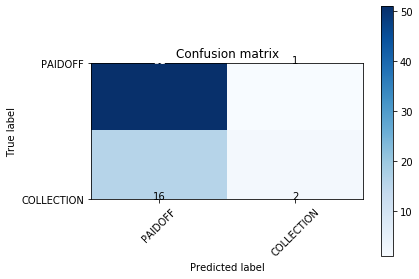

In [452]:
#Evaluation Score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix1 = confusion_matrix(y_test, yhat_lr1, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [453]:
lr_prob1 = log_reg1.predict_proba(X_test)
lr_prob1

array([[0.03, 0.97],
       [0.04, 0.96],
       [0.04, 0.96],
       [0.37, 0.63],
       [0.04, 0.96],
       [0.39, 0.61],
       [0.04, 0.96],
       [0.51, 0.49],
       [0.32, 0.68],
       [0.47, 0.53],
       [0.05, 0.95],
       [0.28, 0.72],
       [0.37, 0.63],
       [0.42, 0.58],
       [0.5 , 0.5 ],
       [0.02, 0.98],
       [0.03, 0.97],
       [0.46, 0.54],
       [0.14, 0.86],
       [0.23, 0.77],
       [0.03, 0.97],
       [0.01, 0.99],
       [0.45, 0.55],
       [0.42, 0.58],
       [0.27, 0.73],
       [0.33, 0.67],
       [0.03, 0.97],
       [0.22, 0.78],
       [0.38, 0.62],
       [0.46, 0.54],
       [0.02, 0.98],
       [0.44, 0.56],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.42, 0.58],
       [0.03, 0.97],
       [0.02, 0.98],
       [0.36, 0.64],
       [0.03, 0.97],
       [0.39, 0.61],
       [0.33, 0.67],
       [0.35, 0.65],
       [0.02, 0.98],
       [0.05, 0.95],
       [0.02, 0.98],
       [0.29, 0.71],
       [0.46, 0.54],
       [0.51,

In [454]:
#Checking our Training and Test set accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, log_reg1.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_lr1))

Train set Accuracy:  0.7536231884057971
Test set Accuracy:  0.7571428571428571


In [455]:
print (classification_report(y_test, yhat_lr1))

              precision    recall  f1-score   support

  COLLECTION       0.67      0.11      0.19        18
     PAIDOFF       0.76      0.98      0.86        52

    accuracy                           0.76        70
   macro avg       0.71      0.55      0.52        70
weighted avg       0.74      0.76      0.69        70



In [456]:
#f1 Score
f1_score(y_test, yhat_lr1, average='weighted') 

0.6857142857142858

In [457]:
#Jaccard Score
jaccard_score(y_test, yhat_lr1,pos_label='PAIDOFF')

0.75

In [458]:
#Log Loss
log_loss(y_test, lr_prob1)

0.43609884179724073

# Model Evaluation using Test set


In [459]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, import and load the test set:


In [460]:
loan_test_csv ='C:\\Python\\loan_test.csv'

### Load Test set for evaluation


In [461]:
test_df = pd.read_csv(loan_test_csv)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [462]:
#Converting date columns to date time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


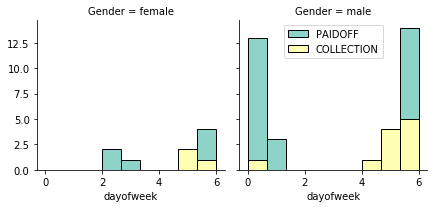

In [463]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [464]:
#Setting threshold to day 4 and creating weekend column since most of the loans not paid back are after day 3
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [465]:
#Gender Feature Binarization
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [466]:
#Creating Feature set
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
#Hot encoding Education feature
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
#Dropping rows with education level Master or Above
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [467]:
#Creating predictor variable
X_eval = Feature_test
X_eval[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [468]:
#Creating response variable
y_eval = test_df['loan_status'].values
y_eval[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [469]:
#Data Normalization
X_eval= preprocessing.StandardScaler().fit(X_eval).transform(X_eval)
X_eval[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [470]:
#KNN prediction
yhat_knn_eval = optimal_knn.predict(X_eval)
yhat_knn_eval[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

In [471]:
print("Test set Accuracy: ", metrics.accuracy_score(y_eval, yhat_knn_eval))

Test set Accuracy:  0.7222222222222222


In [472]:
#f1Score
round(f1_score(y_eval, yhat_knn_eval, average='weighted'),2)

0.67

In [473]:
#Jaccard Index
round(jaccard_score(y_eval, yhat_knn_eval,pos_label='PAIDOFF'),2)

0.71

In [474]:
#Decision Trees Prediction
pred_tree_eval = loanTree.predict(X_eval)

In [475]:
print("Test set Accuracy: ", metrics.accuracy_score(y_eval, pred_tree_eval))

Test set Accuracy:  0.7962962962962963


In [476]:
#f1Score
round(f1_score(y_eval, pred_tree_eval, average='weighted'),2)

0.79

In [477]:
#Jaccard Index
round(jaccard_score(y_eval, pred_tree_eval,pos_label='PAIDOFF'),2)

0.76

In [478]:
#SVM Prediction
yhat_svm_rbf_eval = svm_rbf.predict(X_eval)
yhat_svm_rbf_eval [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [479]:
print("Test set Accuracy: ", metrics.accuracy_score(y_eval, yhat_svm_rbf_eval))

Test set Accuracy:  0.7407407407407407


In [480]:
#f1 Score
round(f1_score(y_eval, yhat_svm_rbf_eval, average='weighted'),2)

0.66

In [481]:
#Jaccard Score
round(jaccard_score(y_eval, yhat_svm_rbf_eval,pos_label='PAIDOFF'),2)

0.74

In [482]:
#Logistic Regression Prediction
yhat_lr1_eval = log_reg1.predict(X_eval)
yhat_lr1_eval

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

In [483]:
lr_prob1_eval = log_reg1.predict_proba(X_eval)
lr_prob1_eval

array([[0.01, 0.99],
       [0.15, 0.85],
       [0.36, 0.64],
       [0.43, 0.57],
       [0.26, 0.74],
       [0.4 , 0.6 ],
       [0.38, 0.62],
       [0.3 , 0.7 ],
       [0.31, 0.69],
       [0.32, 0.68],
       [0.46, 0.54],
       [0.27, 0.73],
       [0.31, 0.69],
       [0.32, 0.68],
       [0.4 , 0.6 ],
       [0.39, 0.61],
       [0.2 , 0.8 ],
       [0.19, 0.81],
       [0.46, 0.54],
       [0.41, 0.59],
       [0.41, 0.59],
       [0.42, 0.58],
       [0.01, 0.99],
       [0.02, 0.98],
       [0.02, 0.98],
       [0.03, 0.97],
       [0.02, 0.98],
       [0.02, 0.98],
       [0.02, 0.98],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.04, 0.96],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.02, 0.98],
       [0.47, 0.53],
       [0.37, 0.63],
       [0.29, 0.71],
       [0.41, 0.59],
       [0.39, 0.61],
       [0.55, 0.45],
       [0.46, 0.54],
       [0.47,

In [484]:
print("Test set Accuracy: ", metrics.accuracy_score(y_eval, yhat_lr1_eval))

Test set Accuracy:  0.7592592592592593


In [485]:
#f1 Score
round(f1_score(y_eval, yhat_lr1_eval, average='weighted'),2)

0.67

In [486]:
#Jaccard Score
round(jaccard_score(y_eval, yhat_lr1_eval,pos_label='PAIDOFF'),2)

0.75

In [487]:
#Log Loss
round(log_loss(y_eval, lr_prob1_eval),2)

0.45

# Report
Accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.71    | 0.67     | NA      |
| Decision Tree      | 0.76    | 0.79     | NA      |
| SVM                | 0.74    | 0.66     | NA      |
| LogisticRegression | 0.75    | 0.67     | 0.45    |
